In [19]:
import math
import sys
import pickle
from math import log10 as log

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

In [4]:
def load():
    return pd.read_csv('dados_voz_genero.csv')

def dataset(data, split=0.8):
    man = data.loc[data['label'] == 1]
    woman = data.loc[data['label'] == 0]

    man.iloc[:int(len(man)*split),:]
    man.iloc[int(len(man)*split):,:]

    woman.iloc[:int(len(woman)*split),:]
    woman.iloc[int(len(woman)*split):,:]

    df_train = pd.concat([
            man.iloc[:int(len(man)*split),:],
            woman.iloc[:int(len(woman)*split),:]],
        ignore_index=True)
    df_test = pd.concat([
        man.iloc[int(len(man)*split):,:],
        woman.iloc[int(len(woman)*split):,:]],
    ignore_index=True)
    
    df_train = shuffle(df_train)
    df_test = shuffle(df_test)
    
    return df_train, df_test

def plot_hist(df):
    #     fig, ax = plt.subplots()
    #     df.hist(figsize=(30,15), ax=ax)
    #     fig.savefig('img1/data_hist.png', dpi=600)
    #     plt.show()
    for col in df.columns:
        fig, ax = plt.subplots()
        ax.set_xlabel(col, fontsize=16)
        ax.set_ylabel("#N", rotation=0)
        ax.grid(color='#919191', linestyle=':', linewidth=1)
        data[col].hist(bins=10)
        fig.savefig('img1/data_hist{}.png'.format(col.replace('.','_')), dpi=300)
        
def plot_corr_heatmap(df):
    plt.figure(figsize=(12,12))
    plt.matshow(df.corr(), fignum=1) 
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    plt.savefig('img1/data_corr.png', dpi=600)
    
def plot_corr_scatter(df):
    fig, ax = plt.subplots()
    scatter_matrix(data, figsize=(35, 35), ax=ax)
    fig.savefig('img1/data_corr_scatter.png', dpi=600)

    plt.show()


In [5]:
def sigmoid(x):
    return 1. / (1. + math.exp(-1*x)) 

def cost_func(y, yest):
    return -1*y*log(yest) + -1*(1-y)*log(1 + -1*yest)

def estimate(w, fi):
    return np.apply_along_axis(sigmoid, 1, fi.T.dot(w)).reshape(-1, 1)

def train(w, fi, eta, tol, y):
    stop = False
    
    # Initial test
    yest = estimate(w, fi)
    e = y - yest
    delta = -1*(e.T.dot(fi.T))/len(fi)
    w = w - delta.T*eta
    prev_err = np.array([ cost_func(y_, yest_) for y_, yest_ in zip(y, yest)]).mean()

    iter_ = 1
    while not stop:
        yest = estimate(w, fi)
        e = y - yest
        delta = -1*(e.T.dot(fi.T))/len(fi)
        w = w - delta.T*eta
        
        err = np.array([ cost_func(y_, yest_) for y_, yest_ in zip(y, yest)]).mean()
        err_delt = prev_err - err
        if err_delt < tol:
            stop = True
        prev_err = err
        sys.stdout.write("\r{}\t{:09.8f}\t{:09.8f}".format(iter_, err, err_delt))
        sys.stdout.flush()
        iter_ += 1
    return w

def predict(yest, boundry):
    return 1 if yest > boundry else 0

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


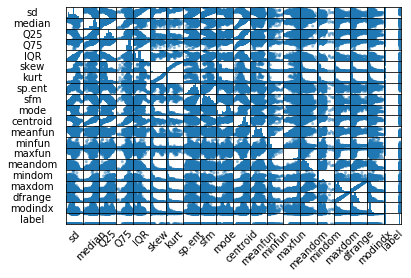

In [6]:
def plot_corr_scatter(df):
    fig, ax = plt.subplots()
    sm = scatter_matrix(data, figsize=(30, 30), marker= ".", ax=ax, diagonal='hist')

    #Change label rotation
    [s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
    [s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

    #May need to offset label when rotating to prevent overlap of figure
    [s.get_yaxis().set_label_coords(-2,0) for s in sm.reshape(-1)]

    #Hide all ticks
    [s.set_xticks(()) for s in sm.reshape(-1)]
    [s.set_yticks(()) for s in sm.reshape(-1)]

    plt.show()
    fig.savefig('img1/data_corr_scatter.png', dpi=600)
    
data = load()
df_train, df_test = dataset(data, split=0.8)
plot_corr_scatter(data)


In [7]:

# Data normalization
scaler = StandardScaler() 
df_train_out = df_train.loc[:,'label']
df_train_inp = df_train.drop('label', axis=1)
scaler.fit(df_train_inp) 
df_train_inp_scaled = scaler.transform(df_train_inp)

In [8]:
# w and fi
ones = np.ones([len(df_train_inp_scaled),1])
fi = np.concatenate((ones, df_train_inp_scaled),axis=1).T
w = np.random.uniform(0,1,(len(fi[:,0]), 1))

# Train
eta = 1e-2
tol = 1e-8
w = train(w, fi, eta, tol, df_train_out.to_numpy().reshape(-1, 1))


4437	0.04032110	0.00000001

In [17]:
# Test
df_test_out = df_train.loc[:,'label']
df_test_inp = df_train.drop('label', axis=1)
df_test_inp_scaled = scaler.transform(df_test_inp)
ones = np.ones([len(df_test_inp_scaled),1])
fi = np.concatenate((ones, df_test_inp_scaled),axis=1).T
yest = estimate(w, fi)


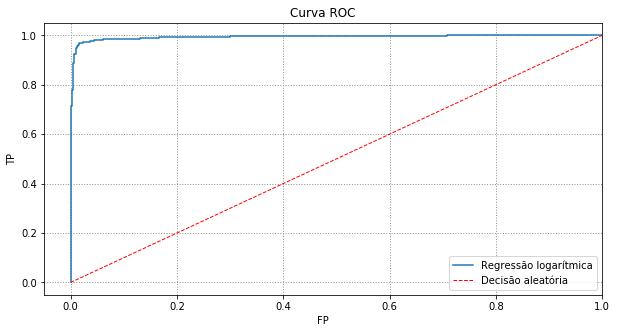

In [20]:
# Results ROC
fpr, tpr, thresholds = roc_curve(df_test_out, yest)
plt.figure(figsize=(10,5))
plt.grid(color='#919191', linestyle=':', linewidth=1)
plt.plot(fpr, tpr, label='Regressão logarítmica')
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Decisão aleatória')
plt.title('Curva ROC')
plt.xlabel('FP')
plt.ylabel('TP')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.grid(True)
plt.legend()
plt.savefig('img1/roc', dpi=300)
plt.show()


In [21]:
boundries = np.linspace(0, 1, 1001)
f_scores = []
y = df_test_out.to_numpy()
for boundry in boundries:
    pred = np.array([predict(yest_, boundry) for yest_ in yest]).reshape(-1, 1)
    f_scores.append(f1_score(y, pred))
best_score = max(f_scores)
best_boundry = boundries[f_scores.index(best_score)]

/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Score 0.9757647993643226	Boundry 0.66


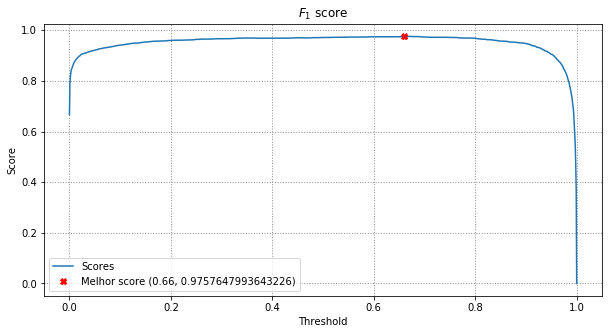

In [12]:
plt.figure(figsize=(10,5))
plt.grid(color='#919191', linestyle=':', linewidth=1)
plt.plot(boundries, f_scores, label='Scores')
plt.plot(best_boundry, best_score, 'rx', marker="X", label='Melhor score ({}, {:4})'.format(best_boundry,best_score))
plt.title('$F_1$ score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.savefig('img1/f1_score')
print('Score {}\tBoundry {}'.format(best_score,best_boundry))

In [27]:
pred = np.array([predict(yest_, best_boundry) for yest_ in yest]).reshape(-1, 1)
cm = confusion_matrix(df_test_out.to_numpy(), pred)
print(cm)
acc = (cm[0][0] + cm[1][1])/np.sum(cm)
taxa_err = (cm[0][1] + cm[1][0])/np.sum(cm)
prec = cm[0][0]/(cm[0][0] + cm[1][0])
recall = cm[0][0]/(cm[0][0] + cm[0][1])


[[1245   22]
 [  39 1228]]


In [23]:
unique, counts = np.unique(pred, return_counts=True)
dict(zip(unique, counts))


{0: 1284, 1: 1250}

(0.969626168224299, 0.9826361483820047, 0.9759273875295975)